In [5]:
import matplotlib.pyplot as plt
import numpy             as np
np.random.seed(123456789)
from numpy.random import rand
from numpy import linspace, cumsum, exp, sqrt
from scipy.stats import norm
from math import log

In [6]:
#
# Normal cumulative distribution function, with extension
# for complex argument with small imaginary component
#

def norm_cdf(x):
    if not isinstance(x, np.ndarray):
        xr = x.real
        xi = x.imag
        if abs(xi) > 1.0e-10:
            raise ValueError('imag(x) too large in norm_cdf(x)')

        ncf = norm.cdf(xr)
        if abs(xi) > 0:
            ncf = ncf + 1.0j*xi*norm.pdf(xr)
    else:
        xr = np.real(x)
        xi = np.imag(x)
        if any(abs(xi) > 1.0e-10):
            raise ValueError('imag(x) too large in norm_cdf(x)')

        ncf = norm.cdf(xr)
        if any(abs(xi) > 0):
            ncf = ncf + 1.0j*xi*norm.pdf(xr)

    return ncf

# V = european_call(r,sigma,T,S,K,opt)
#
# Black-Scholes European call option solution
# as defined in equation (3.17) on page 48 of 
# The Mathematics of Financial Derivatives
# by Wilmott, Howison and Dewynne
#
# r     - interest rate
# sigma - volatility
# T     - time interval
# S     - asset value(s)  (float or flattened numpy array)
# K     - strike price(s) (float or flattened numpy array)
# opt   - 'value', 'delta', 'gamma' or 'vega'
# V     - option value(s) (float or flattened numpy array)
#

def european_call(r,sigma,T,S,K,opt):

    S  = S + 1.0e-100     # avoids problems with S=0
    K  = K + 1.0e-100     # avoids problems with K=0

    d1 = ( log(S) - log(K) + (r+0.5*sigma**2)*T ) / (sigma*sqrt(T))
    d2 = ( log(S) - log(K) + (r-0.5*sigma**2)*T ) / (sigma*sqrt(T))

    if opt == 'value':
        V = S*norm_cdf(d1) - exp(-r*T)*K*norm_cdf(d2)
    elif opt == 'delta':
        V = norm_cdf(d1)
    elif opt == 'gamma':
        V = exp(-0.5*d1**2) / (sigma*sqrt(2*pi*T)*S)
    elif opt == 'vega':
        V =             S*(exp(-0.5*d1**2)/sqrt(2*pi))*( sqrt(T)-d1/sigma) \
            - exp(-r*T)*K*(exp(-0.5*d2**2)/sqrt(2*pi))*(-sqrt(T)-d2/sigma)

    else:
        raise ValueError('invalid value for opt -- must be "value", "delta", "gamma", "vega"')

    return V

Text(0.5, 0, '$U$')

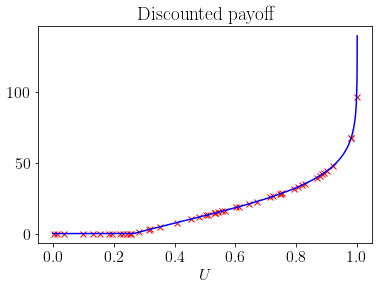

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=16)

plt.close("all")
plt.ion()

r=0.05; sig=0.2; T=1.0; S0=110.0; K=100.0
#
# first figure
#

U1 = rand(1,50)         # uniform random variable
Y1 = norm.ppf(U1)       # inverts Normal cum. fn.
S1 = S0*exp((r-sig**2/2)*T + sig*sqrt(T)*Y1)
F1 = exp(-r*T)*np.maximum(0.0,S1-K)

N  = 10000
U2 = (np.arange(1,N+1)-0.5)/N     # uniformly spaced values
Y2 = norm.ppf(U2)       # inverts Normal cum. fn.
S2 = S0*exp((r-sig**2/2.0)*T + sig*sqrt(T)*Y2)
F2 = exp(-r*T)*np.maximum(0.0,S2-K)

plt.figure()
plt.plot(U1,F1,'rx',U2,F2,'b-')
plt.title('Discounted payoff')
plt.xlabel(r'$U$')

C:\Users\louis\Anaconda3\envs\tfqf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\louis\Anaconda3\envs\tfqf\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\louis\Anaconda3\envs\tfqf\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


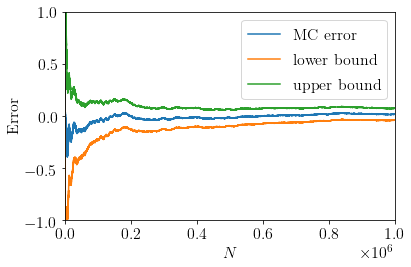

In [7]:
#
# second figure
#

N = np.arange(1, 1000000 + 1)
U = rand(1,max(N))    # uniform random variable
Y = norm.ppf(U)        # inverts Normal cum. fn.
S = S0*exp((r-sig**2/2.0)*T + sig*sqrt(T)*Y)
F = exp(-r*T)*np.maximum(0.0,S-K)

sum1 = cumsum(F)      # cumulative summation of
sum2 = cumsum(F**2)   # payoff and its square
val = sum1/N
rms = sqrt(sum2/N - val**2)

err = european_call(r,sig,T,S0,K,'value') - val

fig = plt.figure()
plt.plot(N, err, N, err - 3.0*rms/sqrt(N), N, err+3*rms/sqrt(N))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.axis([0, len(N), -1, 1])
plt.xlabel(r'$N$'); plt.ylabel('Error')
plt.legend(('MC error', 'lower bound', 'upper bound'))
fig.tight_layout()